In [24]:
import yfinance as yf

tickers = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'META', 'NVDA']
data = yf.download(tickers, start="2015-01-01", interval="1d", group_by='ticker')

with open('./data/raw/mag7_prices.csv', 'w') as f:
    # Write header
    f.write('Date,Ticker,Open,High,Low,Close,Volume\n')
    
    # Write data rows
    for date in data.index:
        for ticker in tickers:
            row = [
                date.strftime('%Y-%m-%d'),
                ticker,
                str(data[ticker]['Open'].loc[date]),
                str(data[ticker]['High'].loc[date]),
                str(data[ticker]['Low'].loc[date]),
                str(data[ticker]['Close'].loc[date]),
                str(data[ticker]['Volume'].loc[date])
            ]
            f.write(','.join(row) + '\n')

/var/folders/ng/hs3dclln4lv73c8vrw4wy0m40000gn/T/ipykernel_50654/3755396242.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2015-01-01", interval="1d", group_by='ticker')
[*********************100%***********************]  7 of 7 completed



## Load and Clean Data
Load the MAG7 prices data, handle missing values, and align dates across all tickers.

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set colorblind-friendly palette with bright, distinct colors
colors = ['#0173B2', '#DE8F05', '#029E73', '#CC78BC', '#CA9161', '#FBAFE4', '#949494']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11

# Load the data
df = pd.read_csv('./data/raw/mag7_prices.csv')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst few rows:")

print(df.head())
print(df['Ticker'].unique())

print("\nData types:")
print("\nUnique tickers:")

print(df.dtypes)
print(df.isnull().sum())
print("\nMissing values:")

Dataset shape: (19222, 7)

First few rows:
         Date Ticker       Open       High        Low      Close     Volume
0  2015-01-02   AAPL  24.694243  24.705328  23.798608  24.237558  212818400
1  2015-01-02   MSFT  39.773205  40.421031  39.670917  39.858444   27913900
2  2015-01-02   GOOG  26.198793  26.310719  25.955630  25.990791   28951268
3  2015-01-02   AMZN  15.629000  15.737500  15.348000  15.426000   55664000
4  2015-01-02   TSLA  14.858000  14.883333  14.217333  14.620667   71466000
['AAPL' 'MSFT' 'GOOG' 'AMZN' 'TSLA' 'META' 'NVDA']

Data types:

Unique tickers:
Date       object
Ticker     object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object
Date      0
Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Missing values:


In [29]:
# Convert Date to datetime and sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)

# Check date range for each ticker
print("Date range by ticker:")
for ticker in df['Ticker'].unique():
    ticker_data = df[df['Ticker'] == ticker]
    print(f"{ticker}: {ticker_data['Date'].min()} to {ticker_data['Date'].max()} ({len(ticker_data)} records)")

# Check for missing dates
print("\n\nChecking for date alignment issues...")
all_dates = df.groupby('Ticker')['Date'].apply(set)
common_dates = set.intersection(*all_dates.values)
print(f"Common dates across all tickers: {len(common_dates)}")

for ticker in df['Ticker'].unique():
    ticker_dates = all_dates[ticker]
    missing = len(common_dates) - len(ticker_dates)
    if missing != 0:
        print(f"{ticker}: missing {abs(missing)} dates")

Date range by ticker:
AAPL: 2015-01-02 00:00:00 to 2025-12-02 00:00:00 (2746 records)
AMZN: 2015-01-02 00:00:00 to 2025-12-02 00:00:00 (2746 records)
GOOG: 2015-01-02 00:00:00 to 2025-12-02 00:00:00 (2746 records)
META: 2015-01-02 00:00:00 to 2025-12-02 00:00:00 (2746 records)
MSFT: 2015-01-02 00:00:00 to 2025-12-02 00:00:00 (2746 records)
NVDA: 2015-01-02 00:00:00 to 2025-12-02 00:00:00 (2746 records)
TSLA: 2015-01-02 00:00:00 to 2025-12-02 00:00:00 (2746 records)


Checking for date alignment issues...
Common dates across all tickers: 2746


In [30]:
# Filter to only include dates common to all tickers
df_aligned = df[df['Date'].isin(common_dates)].copy()

print(f"Original dataset: {len(df)} rows")
print(f"Aligned dataset: {len(df_aligned)} rows")
print(f"Rows removed: {len(df) - len(df_aligned)}")

# Check for missing values in price columns
print("\n\nMissing values after alignment:")
print(df_aligned.isnull().sum())

# Remove rows with any missing price data
df_clean = df_aligned.dropna().copy()
print(f"\nAfter removing NaN values: {len(df_clean)} rows")

# Verify all tickers have same number of records
print("\n\nRecords per ticker after cleaning:")
print(df_clean.groupby('Ticker').size())

Original dataset: 19222 rows
Aligned dataset: 19222 rows
Rows removed: 0


Missing values after alignment:
Date      0
Ticker    0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

After removing NaN values: 19222 rows


Records per ticker after cleaning:
Ticker
AAPL    2746
AMZN    2746
GOOG    2746
META    2746
MSFT    2746
NVDA    2746
TSLA    2746
dtype: int64


## Exploratory Data Analysis (EDA)
Analyze price trends, volumes, and statistics across the MAG7 stocks.

In [31]:
# Summary statistics for each ticker
print("Summary Statistics by Ticker:\n")
for ticker in df_clean['Ticker'].unique():
    ticker_data = df_clean[df_clean['Ticker'] == ticker]
    print(f"\n{ticker}:")
    print(ticker_data[['Open', 'High', 'Low', 'Close', 'Volume']].describe())

Summary Statistics by Ticker:


AAPL:
              Open         High          Low        Close        Volume
count  2746.000000  2746.000000  2746.000000  2746.000000  2.746000e+03
mean    104.990027   106.138871   103.939030   105.092701  1.119105e+08
std      73.074651    73.875309    72.374703    73.169815  6.798929e+07
min      20.526537    20.907418    20.405654    20.604076  2.013560e+07
25%      36.586246    36.871827    36.244279    36.527093  6.543772e+07
50%      85.210792    85.874051    83.815167    85.279903  9.483350e+07
75%     167.701550   169.305949   166.525919   167.729385  1.375076e+08
max     283.000000   287.399994   282.630005   286.190002  6.488252e+08

AMZN:
              Open         High          Low        Close        Volume
count  2746.000000  2746.000000  2746.000000  2746.000000  2.746000e+03
mean    110.938746   112.193511   109.558081   110.905026  7.355834e+07
std      61.187509    61.856410    60.424219    61.139539  4.023055e+07
min      14.314000 

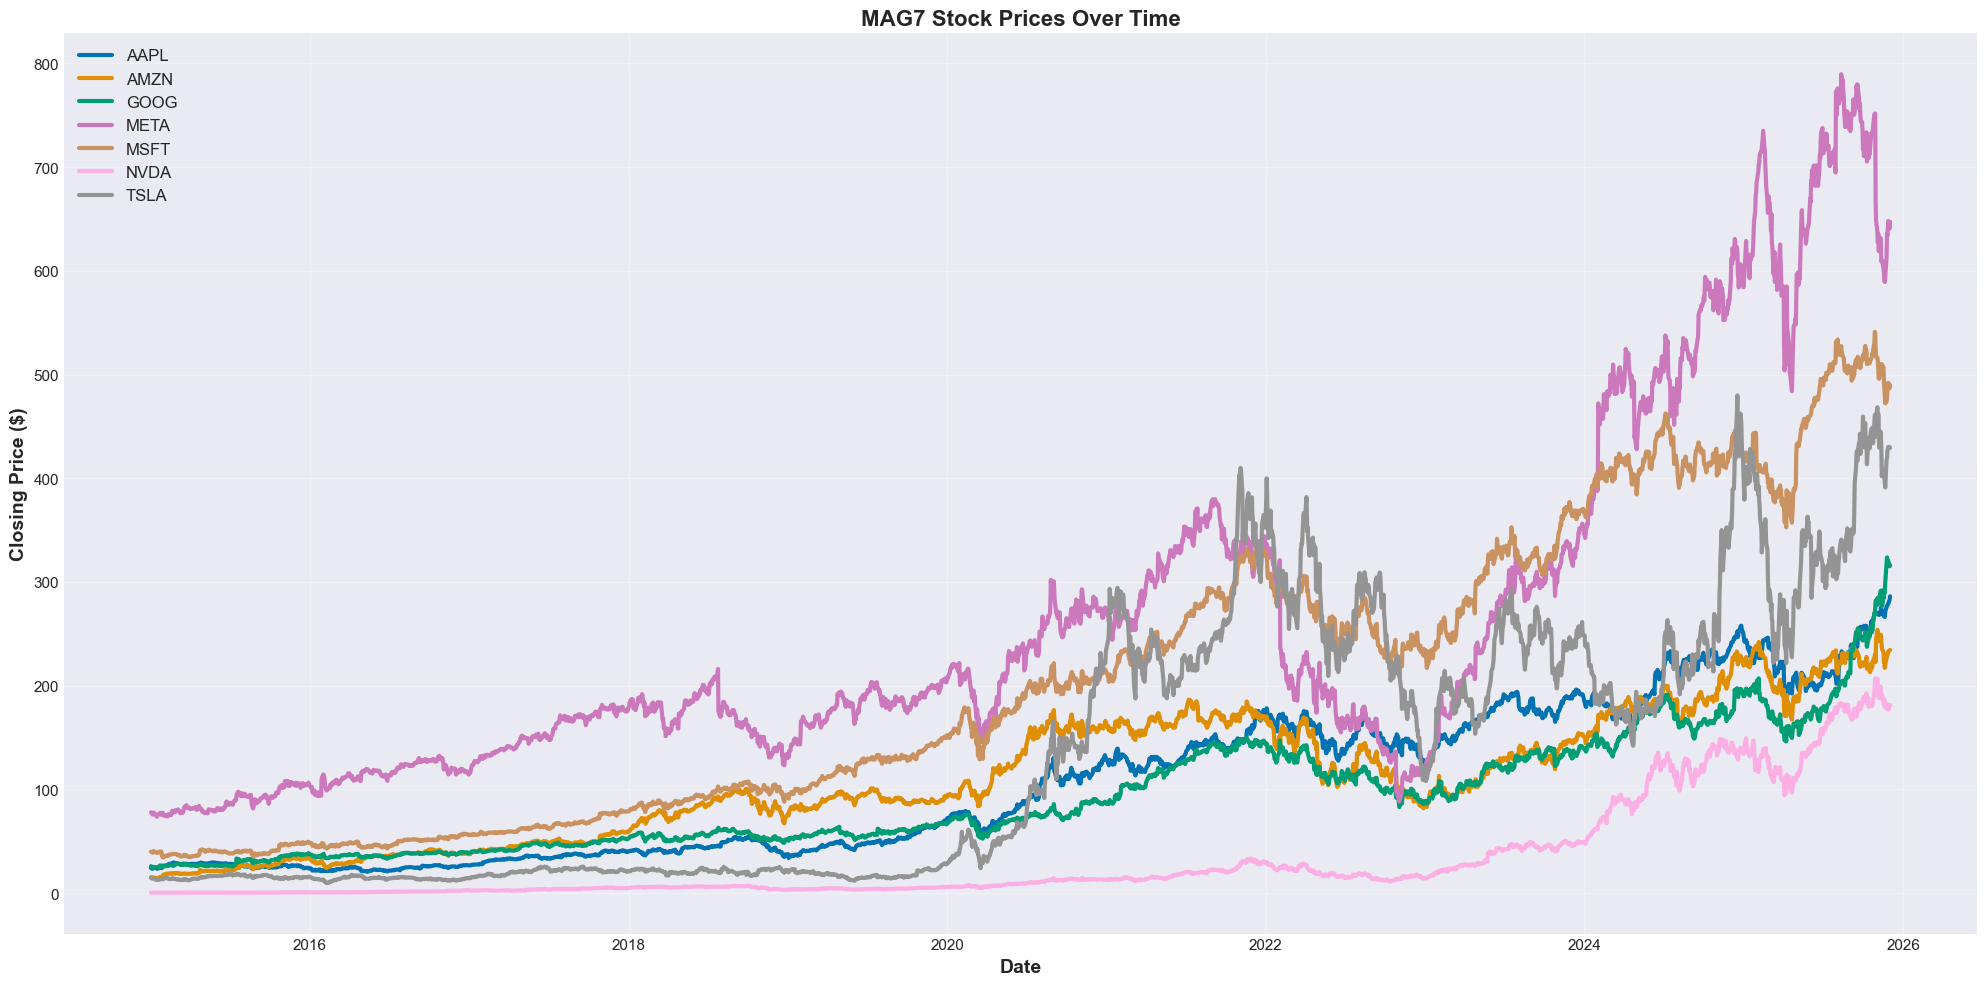

Price trends show the historical performance of each stock.


In [32]:
# Plot closing prices over time
fig, ax = plt.subplots(figsize=(20, 10))
for idx, ticker in enumerate(sorted(df_clean['Ticker'].unique())):
    ticker_data = df_clean[df_clean['Ticker'] == ticker]
    ax.plot(ticker_data['Date'], ticker_data['Close'], label=ticker, 
            linewidth=3, color=colors[idx])

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Closing Price ($)', fontsize=14, fontweight='bold')
ax.set_title('MAG7 Stock Prices Over Time', fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()

print("Price trends show the historical performance of each stock.")

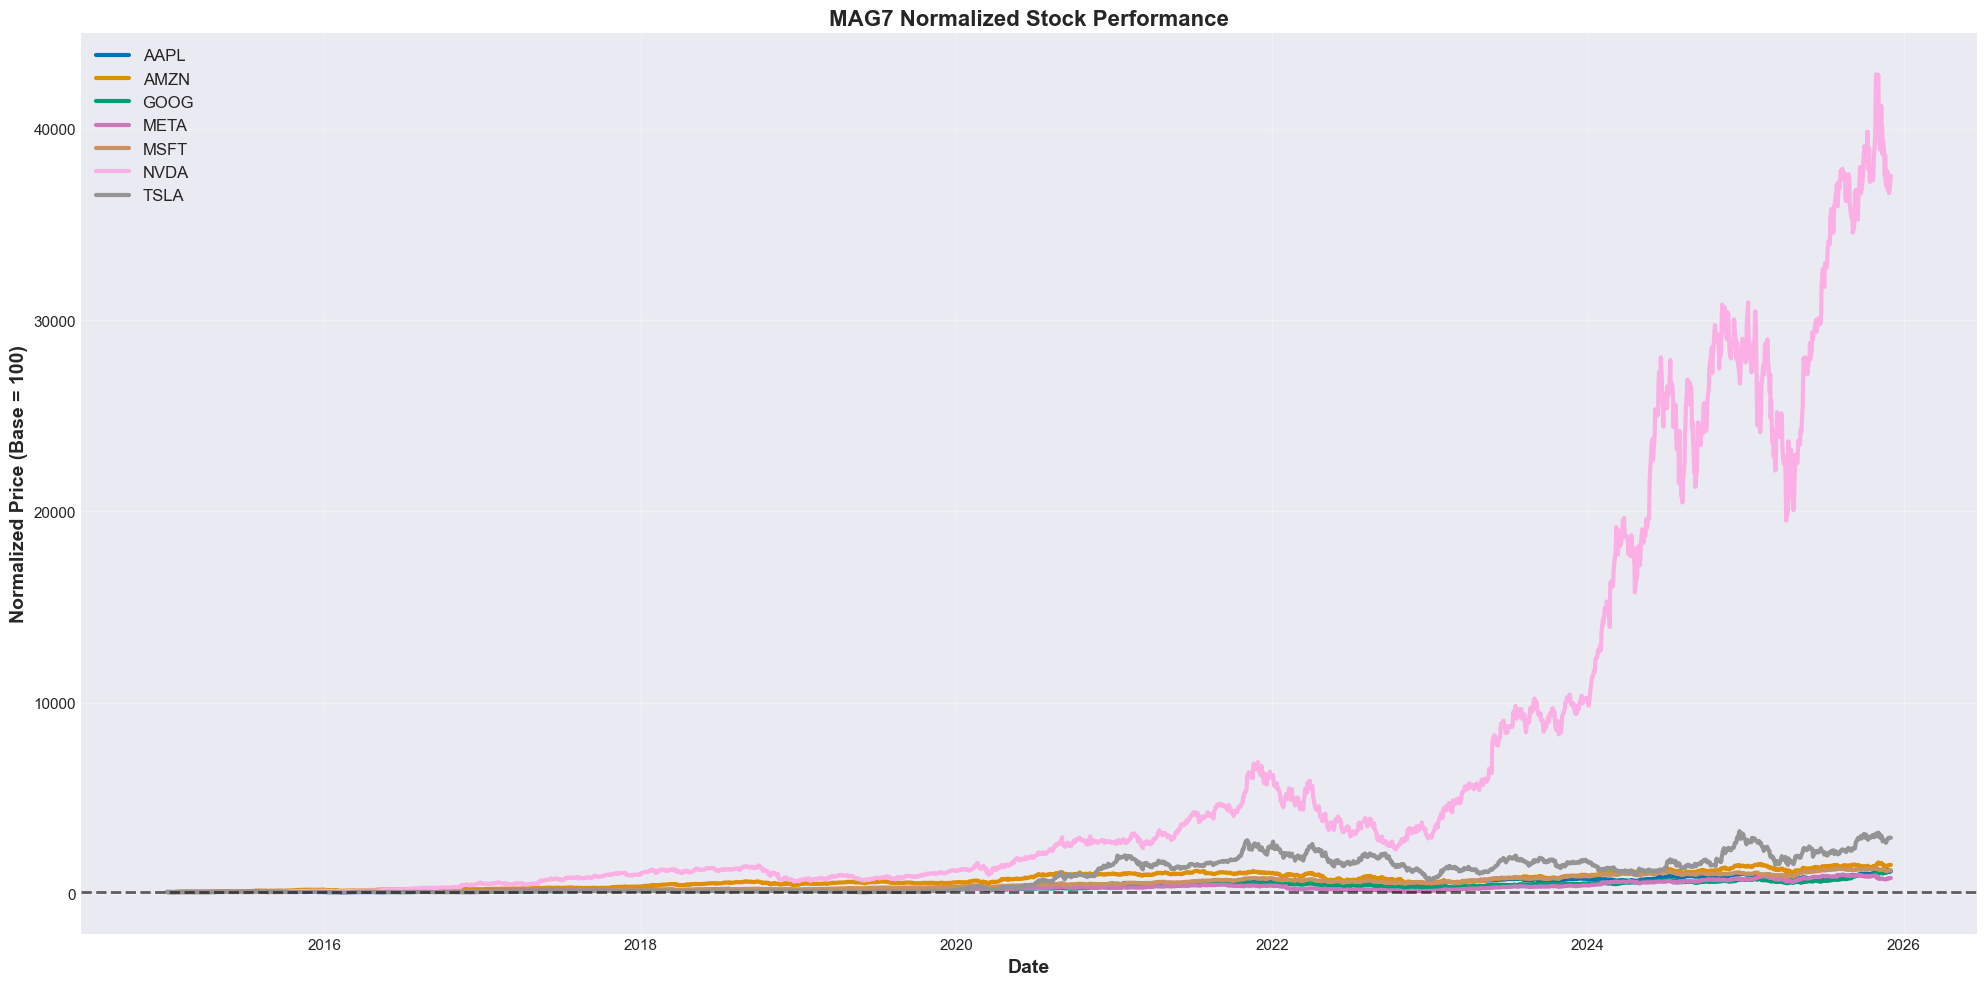

Normalized prices show relative performance from the start date.


In [33]:
# Normalize prices to show relative performance (base = 100 at start date)
fig, ax = plt.subplots(figsize=(20, 10))
for idx, ticker in enumerate(sorted(df_clean['Ticker'].unique())):
    ticker_data = df_clean[df_clean['Ticker'] == ticker].sort_values('Date')
    normalized = (ticker_data['Close'] / ticker_data['Close'].iloc[0]) * 100
    ax.plot(ticker_data['Date'], normalized, label=ticker, 
            linewidth=3, color=colors[idx])

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Normalized Price (Base = 100)', fontsize=14, fontweight='bold')
ax.set_title('MAG7 Normalized Stock Performance', fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1)
ax.axhline(y=100, color='#000000', linestyle='--', linewidth=2, alpha=0.6)
plt.tight_layout()
plt.show()

print("Normalized prices show relative performance from the start date.")

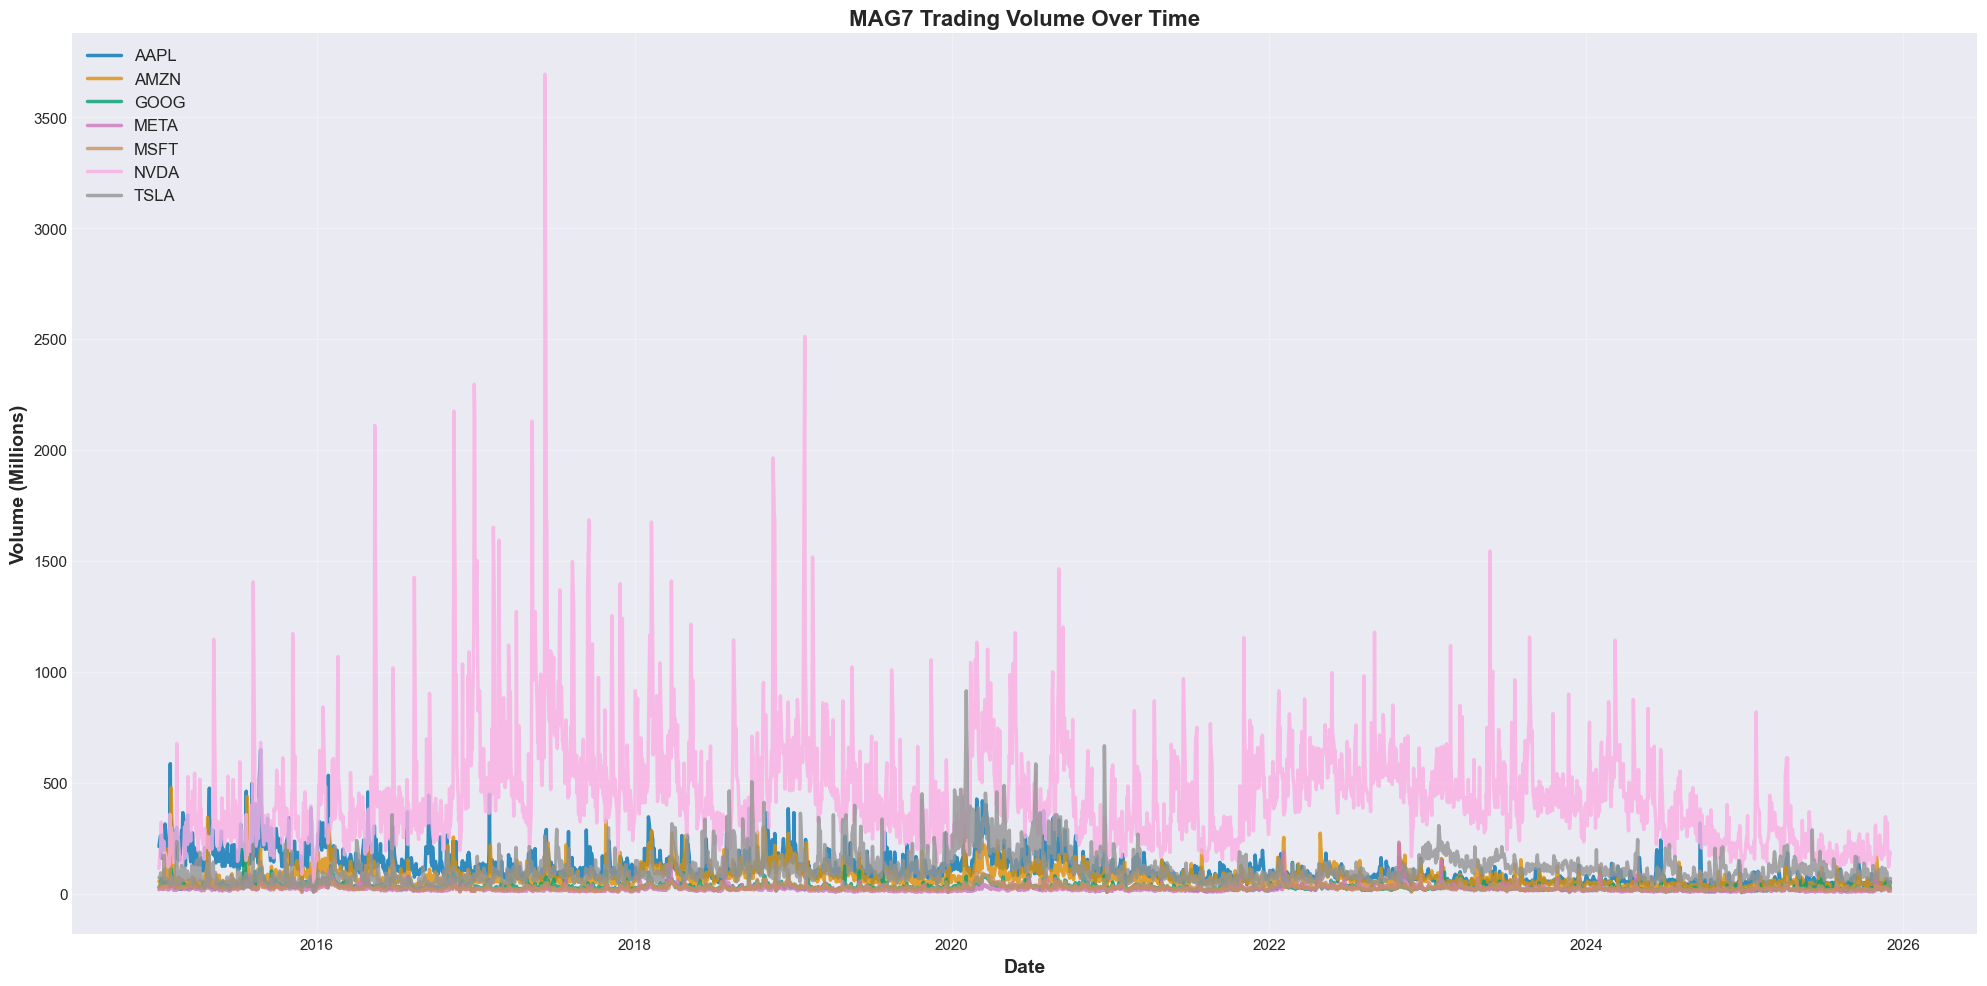


Average daily trading volume (millions):
Ticker
NVDA    447.374162
AAPL    111.910519
TSLA    111.250751
AMZN     73.558339
GOOG     30.200015
MSFT     28.316035
META     22.262627
Name: Volume, dtype: float64


In [34]:
# Trading volume analysis
fig, ax = plt.subplots(figsize=(20, 10))
for idx, ticker in enumerate(sorted(df_clean['Ticker'].unique())):
    ticker_data = df_clean[df_clean['Ticker'] == ticker]
    ax.plot(ticker_data['Date'], ticker_data['Volume'] / 1e6, label=ticker, 
            linewidth=2.5, alpha=0.8, color=colors[idx])

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Volume (Millions)', fontsize=14, fontweight='bold')
ax.set_title('MAG7 Trading Volume Over Time', fontsize=16, fontweight='bold')
ax.legend(loc='upper left', fontsize=12, framealpha=0.9)
ax.grid(True, alpha=0.3, linewidth=1)
plt.tight_layout()
plt.show()

# Average volume by ticker
print("\nAverage daily trading volume (millions):")
avg_volumes = df_clean.groupby('Ticker')['Volume'].mean() / 1e6
print(avg_volumes.sort_values(ascending=False))

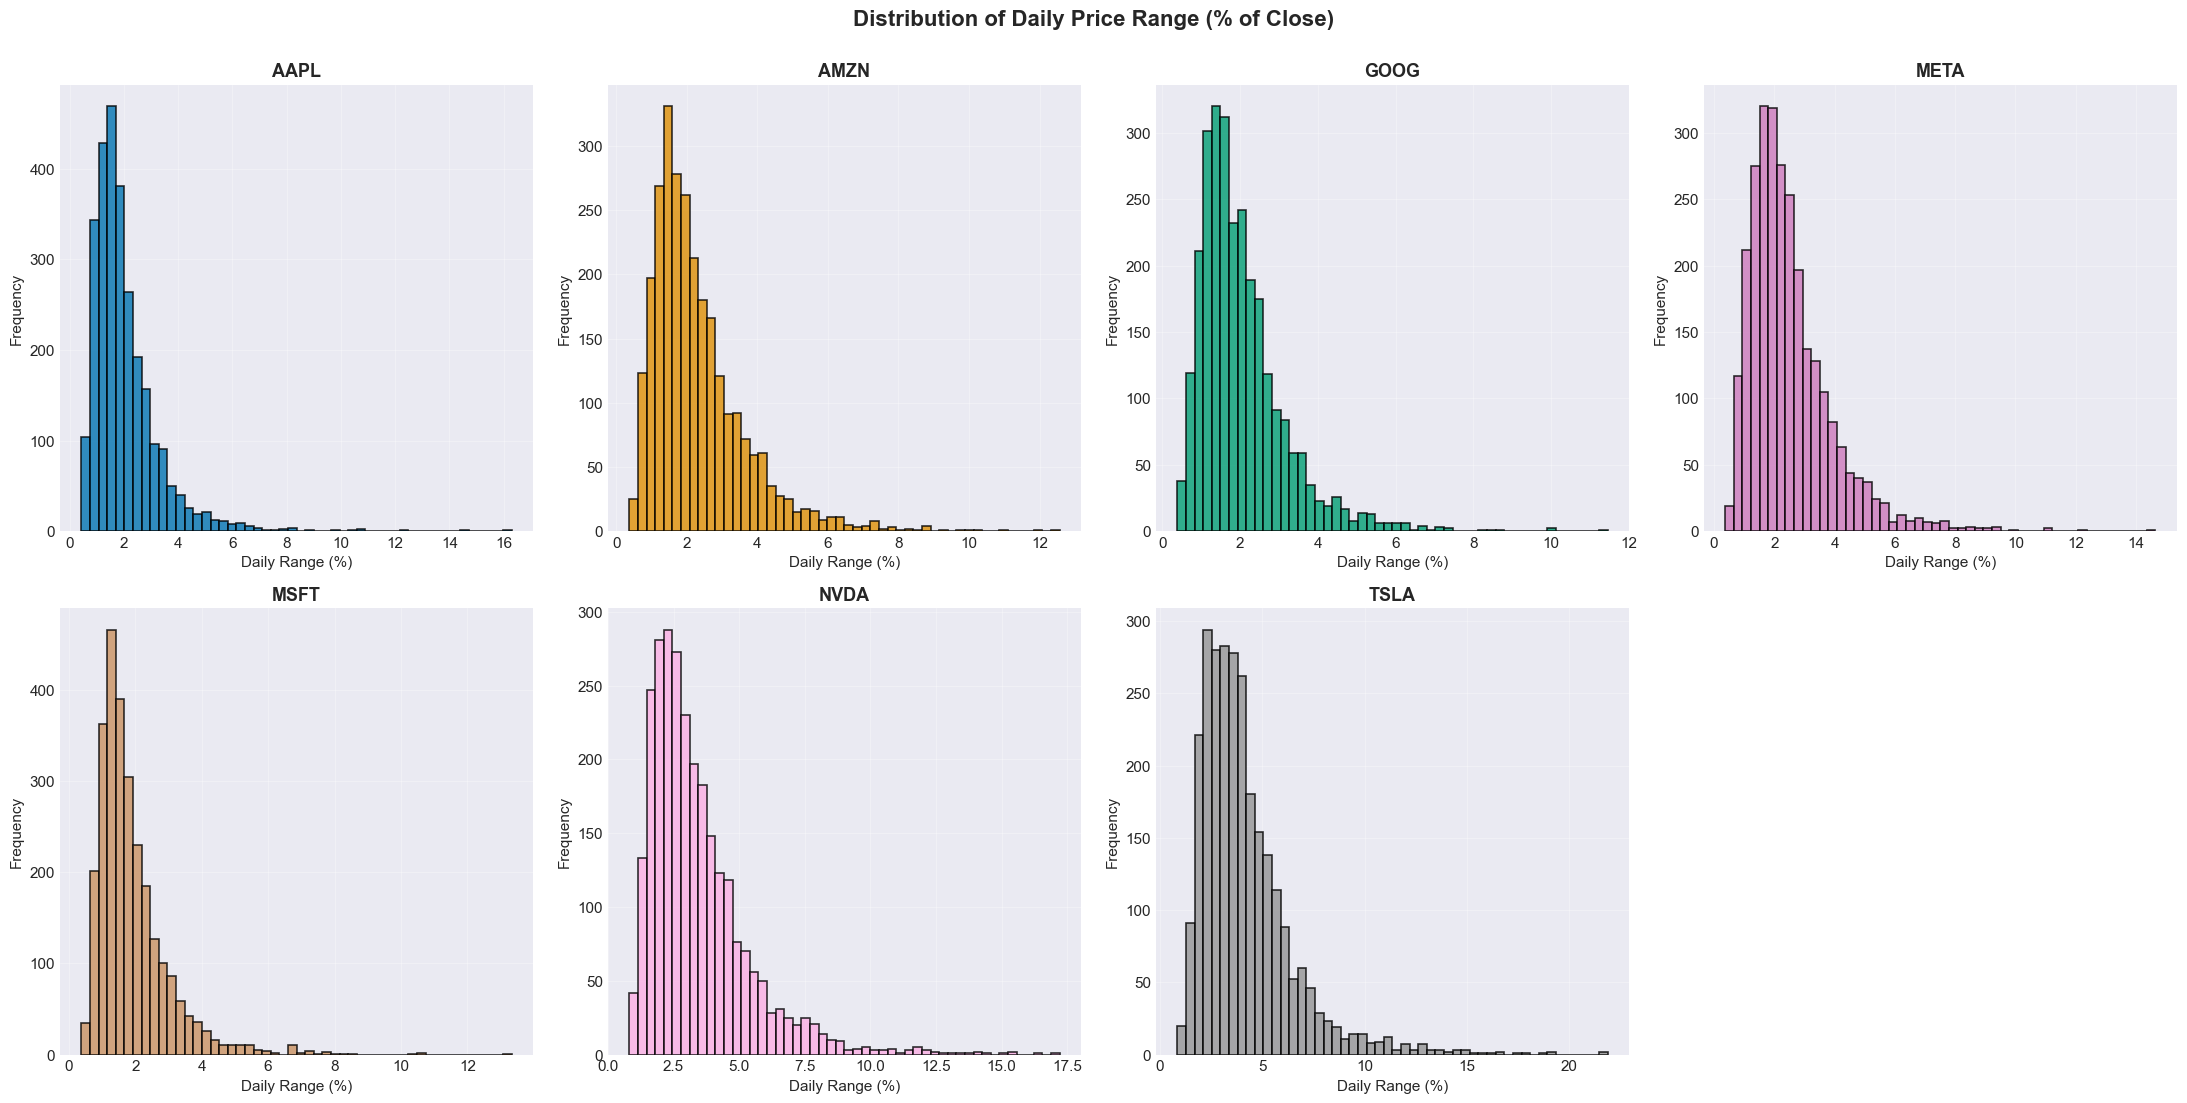


Average daily price range (% of Close):
Ticker
TSLA    4.157141
NVDA    3.428029
META    2.506591
AMZN    2.311707
GOOG    2.036931
AAPL    2.023208
MSFT    1.902365
Name: Price_Range_Pct, dtype: float64


In [35]:
# Daily price range (High - Low) as percentage of Close
df_clean['Price_Range_Pct'] = ((df_clean['High'] - df_clean['Low']) / df_clean['Close']) * 100

fig, axes = plt.subplots(2, 4, figsize=(22, 11))
axes = axes.flatten()

for idx, ticker in enumerate(sorted(df_clean['Ticker'].unique())):
    ticker_data = df_clean[df_clean['Ticker'] == ticker]
    axes[idx].hist(ticker_data['Price_Range_Pct'], bins=50, alpha=0.8, 
                   color=colors[idx], edgecolor='black', linewidth=1.2)
    axes[idx].set_title(f'{ticker}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Daily Range (%)', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].grid(True, alpha=0.3, linewidth=0.8)

# Remove the 8th subplot
axes[7].axis('off')

plt.suptitle('Distribution of Daily Price Range (% of Close)', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nAverage daily price range (% of Close):")
print(df_clean.groupby('Ticker')['Price_Range_Pct'].mean().sort_values(ascending=False))

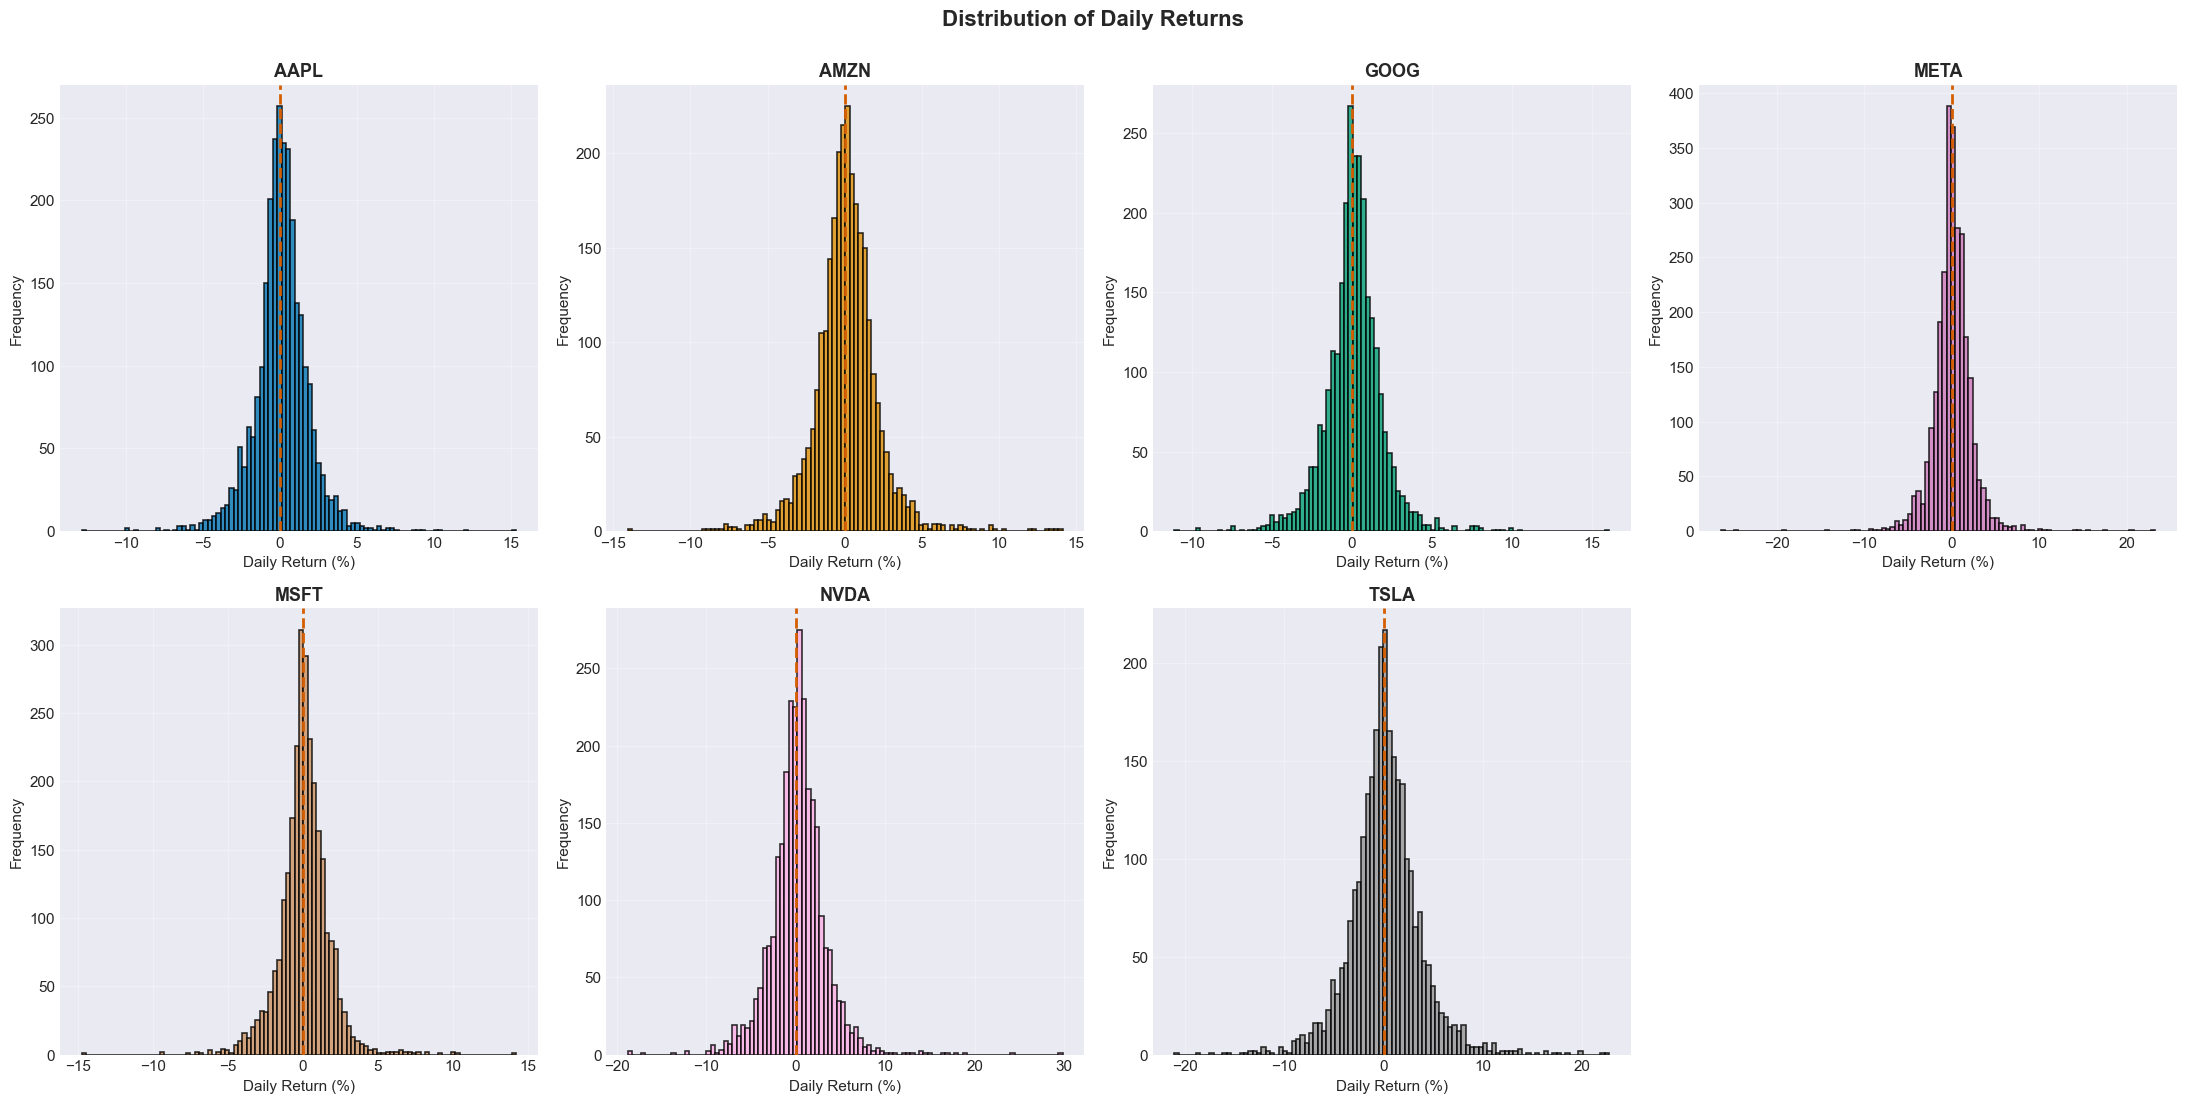


Daily return statistics:
            mean       std        min        max
Ticker                                          
AAPL    0.106562  1.822750 -12.864703  15.328841
AMZN    0.120685  2.079730 -14.049438  14.131126
GOOG    0.107528  1.818710 -11.100814  16.052420
META    0.105474  2.370156 -26.390087  23.282409
MSFT    0.105827  1.697358 -14.739020  14.216904
NVDA    0.263012  3.074251 -18.755836  29.806693
TSLA    0.189318  3.645335 -21.062824  22.689990


In [36]:
# Calculate daily returns
df_clean = df_clean.sort_values(['Ticker', 'Date'])
df_clean['Daily_Return'] = df_clean.groupby('Ticker')['Close'].pct_change() * 100

# Distribution of daily returns
fig, axes = plt.subplots(2, 4, figsize=(22, 11))
axes = axes.flatten()

for idx, ticker in enumerate(sorted(df_clean['Ticker'].unique())):
    ticker_data = df_clean[df_clean['Ticker'] == ticker].dropna()
    axes[idx].hist(ticker_data['Daily_Return'], bins=100, alpha=0.8, 
                   color=colors[idx], edgecolor='black', linewidth=1.2)
    axes[idx].set_title(f'{ticker}', fontsize=13, fontweight='bold')
    axes[idx].set_xlabel('Daily Return (%)', fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].axvline(x=0, color='#D55E00', linestyle='--', linewidth=2)
    axes[idx].grid(True, alpha=0.3, linewidth=0.8)

axes[7].axis('off')

plt.suptitle('Distribution of Daily Returns', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\nDaily return statistics:")
return_stats = df_clean.groupby('Ticker')['Daily_Return'].agg(['mean', 'std', 'min', 'max'])
print(return_stats)

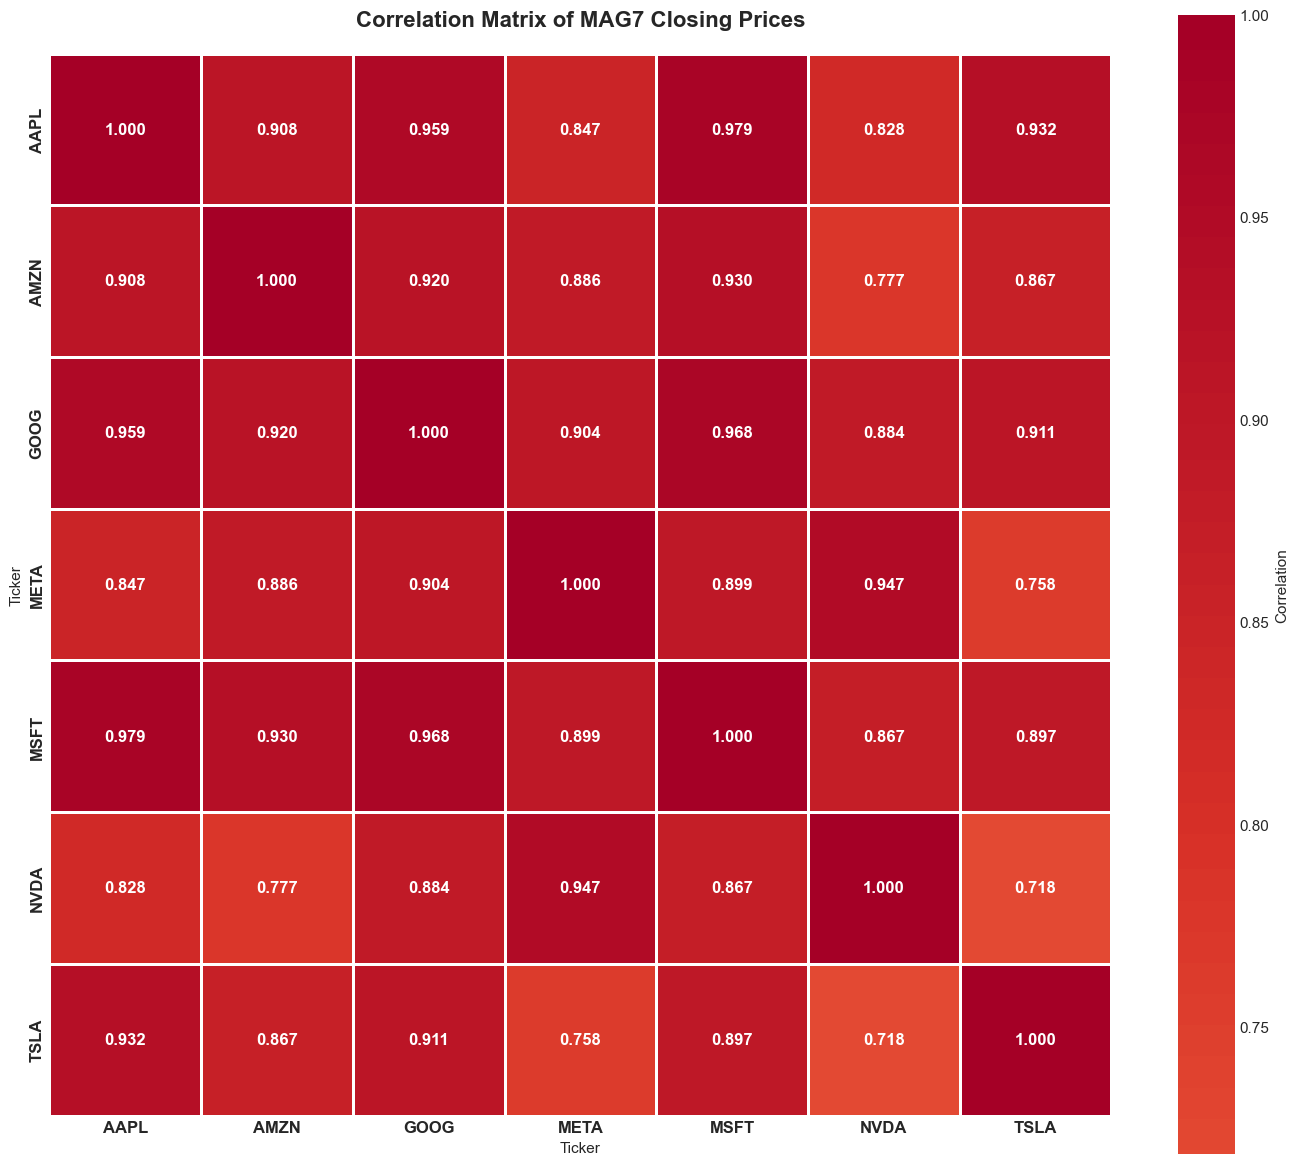

Correlation matrix shows how stock prices move together.


In [38]:
# Correlation matrix of closing prices
pivot_close = df_clean.pivot(index='Date', columns='Ticker', values='Close')

fig, ax = plt.subplots(figsize=(14, 12))
correlation_matrix = pivot_close.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='RdYlBu_r', 
            center=0, square=True, ax=ax, cbar_kws={'label': 'Correlation'},
            linewidths=2, linecolor='white', annot_kws={'size': 12, 'weight': 'bold'})
ax.set_title('Correlation Matrix of MAG7 Closing Prices', fontsize=16, fontweight='bold', pad=20)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, fontweight='bold')
ax.set_yticklabels(ax.get_yticklabels(), fontsize=12, fontweight='bold')
plt.tight_layout()

plt.show()
print("Correlation matrix shows how stock prices move together.")


## Save Cleaned Data
Save the cleaned and aligned dataset for future analysis.

In [39]:
# Save cleaned data
output_path = './data/processed/mag7_prices_cleaned.csv'
df_clean.to_csv(output_path, index=False)

print(f"Cleaned data saved to: {output_path}")
print(f"\nFinal dataset shape: {df_clean.shape}")
print(f"Date range: {df_clean['Date'].min()} to {df_clean['Date'].max()}")
print(f"Number of trading days: {len(df_clean['Date'].unique())}")
print(f"Tickers: {sorted(df_clean['Ticker'].unique())}")

Cleaned data saved to: ./data/processed/mag7_prices_cleaned.csv

Final dataset shape: (19222, 9)
Date range: 2015-01-02 00:00:00 to 2025-12-02 00:00:00
Number of trading days: 2746
Tickers: ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA', 'TSLA']
